In [1]:
# INSTALL & IMPORTS 


# Install essential NLP & Hugging Face libraries
!pip install -q transformers datasets evaluate accelerate
!pip install -q textblob unidecode langdetect


# Core Libraries

import os, re, string
import numpy as np
import pandas as pd
from collections import Counter


# Visualization

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.subplots as sp

plt.style.use('seaborn-deep')
sns.set_context('talk')


# NLP & Text Processing

import nltk
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from textblob import TextBlob
from langdetect import detect

# Optional: emoji support
try:
    import emoji
    HAS_EMOJI = True
except Exception:
    HAS_EMOJI = False


# ML & Feature Extraction

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


# Deep Learning (Transformers)

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    get_linear_schedule_with_warmup
)
from torch.optim import AdamW


# Gradient Boosting (LightGBM)

import lightgbm as lgb
from scipy.sparse import hstack, csr_matrix



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


/var/folders/66/qj0pgbn10_n7_txykj6jtj2c0000gn/T/ipykernel_84658/1826339983.py:25: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-deep')


In [2]:
# Quick checks you can add (optional):
print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

Torch version: 2.7.1
CUDA available: False


In [3]:
train_df = pd.read_csv("train.csv")
test_df  = pd.read_csv("test.csv")

In [4]:
def quick_overview(df, text_col='text', target_col='target'):
    print("Shape:", df.shape)
    print("\nColumns and dtypes:\n", df.dtypes)
    print("\nNulls per column:\n", df.isnull().sum())
    if text_col in df.columns:
        print(f"\nUnique {text_col}: {df[text_col].nunique()}")
        print(f"Duplicate rows (full): {df.duplicated().sum()}")
        print(f"Duplicate {text_col}: {df[text_col].duplicated().sum()}")
    if target_col in df.columns:
        print(f"\nTarget value counts:\n{df[target_col].value_counts(dropna=False)}")


quick_overview(train_df, text_col='text', target_col='target')


Shape: (7613, 5)

Columns and dtypes:
 id           int64
keyword     object
location    object
text        object
target       int64
dtype: object

Nulls per column:
 id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

Unique text: 7503
Duplicate rows (full): 0
Duplicate text: 110

Target value counts:
target
0    4342
1    3271
Name: count, dtype: int64


In [5]:
def plot_target_dist_interactive(df, target_col='target'):
    counts = df[target_col].value_counts().reset_index()
    counts.columns = [target_col, 'count']
    counts['percentage'] = (counts['count'] / counts['count'].sum() * 100).round(2)
    
    fig = px.bar(
        counts, 
        x=target_col, 
        y='count', 
        text='percentage',
        color=target_col,
        color_continuous_scale='Tealgrn',
        title='Target Distribution',
        labels={target_col: 'Target', 'count': 'Count'},
    )
    
    fig.update_traces(
        texttemplate='%{text}%',
        textposition='outside'
    )
    
    fig.update_layout(
        uniformtext_minsize=10,
        uniformtext_mode='hide',
        yaxis=dict(title='Count'),
        xaxis=dict(title='Target (0 = Not Disaster, 1 = Disaster)'),
        showlegend=False,
        template='plotly_white'
    )
    
    fig.show()
    
    # Print proportions for reference
    print(df[target_col].value_counts(normalize=True).rename('proportion'))

plot_target_dist_interactive(train_df, target_col='target')


target
0    0.57034
1    0.42966
Name: proportion, dtype: float64


In [6]:
def show_empty_texts(df, text_col='text', n=10):
    is_empty = df[text_col].isnull() | (df[text_col].astype(str).str.strip()=='')
    print("Empty text count:", is_empty.sum())
    if is_empty.sum() > 0:
        display(df[is_empty].head(n))

show_empty_texts(train_df, text_col='text')


Empty text count: 0


In [7]:
def text_length_stats_interactive(df, text_col='text'):
    df = df.copy()
    df['char_len'] = df[text_col].astype(str).apply(len)
    df['word_len'] = df[text_col].astype(str).apply(lambda x: len(x.split()))

    # Show percentiles summary
    display(df[['char_len','word_len']].describe(percentiles=[0.25,0.5,0.75,0.9,0.95]).T)

    # Create interactive subplots
    fig = sp.make_subplots(rows=1, cols=2, subplot_titles=('Character Length Distribution', 'Word Count Distribution'))

    fig.add_trace(
        go.Histogram(x=df['char_len'], nbinsx=60, name='Character Length', marker_color='steelblue', opacity=0.8),
        row=1, col=1
    )
    fig.add_trace(
        go.Histogram(x=df['word_len'], nbinsx=60, name='Word Count', marker_color='seagreen', opacity=0.8),
        row=1, col=2
    )

    fig.update_layout(
        title_text="Tweet Length Analysis (Characters & Words)",
        template='plotly_white',
        bargap=0.05,
        showlegend=False,
        height=450,
    )
    fig.update_xaxes(title_text="char_len", row=1, col=1)
    fig.update_xaxes(title_text="word_len", row=1, col=2)
    fig.update_yaxes(title_text="Count", row=1, col=1)
    fig.update_yaxes(title_text="Count", row=1, col=2)

    fig.show()

    return df

len_df = text_length_stats_interactive(train_df, text_col='text')


,count,mean,std,min,25%,50%,75%,90%,95%,max
char_len,7613.0,101.037436,33.781325,7.0,78.0,107.0,133.0,138.0,140.0,157.0
word_len,7613.0,14.903586,5.732604,1.0,11.0,15.0,19.0,22.0,24.0,31.0


In [8]:
def show_short_long_examples(df, text_col='text', target_col='target', n=3):
    for t in sorted(df[target_col].unique()):
        sub = df[df[target_col]==t].copy()
        sub['char_len'] = sub[text_col].astype(str).apply(len)
        print(f"\n--- Target = {t} | shortest {n} ---")
        display(sub.sort_values('char_len').head(n)[[text_col,'char_len']])
        print(f"\n--- Target = {t} | longest {n} ---")
        display(sub.sort_values('char_len', ascending=False).head(n)[[text_col,'char_len']])

show_short_long_examples(train_df, text_col='text', target_col='target', n=3)



--- Target = 0 | shortest 3 ---


,text,char_len
4890,Bad day,7
5115,Err:509,7
1882,Crushed,7



--- Target = 0 | longest 3 ---


,text,char_len
1270,when you're taking a shower and someone flushe...,157
4801,It's was about 2:30 in the morning&amp;I went ...,152
261,@Barbi_Twins We need help-horses will die! Ple...,148



--- Target = 1 | shortest 3 ---


,text,char_len
7589,Omg earthquake,14
4504,hurricane?? sick!,17
4894,I see a massacre!!,18



--- Target = 1 | longest 3 ---


,text,char_len
614,@CAgov If 90BLKs&amp;8WHTs colluded 2 take WHT...,151
633,@HowardU If 90BLKs&amp;8WHTs colluded 2 take W...,150
635,@cspanwj If 90BLKs&amp;8WHTs colluded 2 take W...,150


In [9]:
url_pattern = r'http\S+|www\.\S+'
mention_pattern = r'@\w+'
hashtag_pattern = r'#\w+'
number_pattern = r'\d+'

def add_text_features(df, text_col='text'):
    df = df.copy()
    df['text_clean'] = df[text_col].astype(str)
    df['has_url'] = df['text_clean'].str.contains(url_pattern).fillna(False)
    df['n_urls'] = df['text_clean'].str.count(url_pattern)
    df['n_mentions'] = df['text_clean'].str.count(mention_pattern)
    df['n_hashtags'] = df['text_clean'].str.count(hashtag_pattern)
    df['n_numbers'] = df['text_clean'].str.count(number_pattern)
    df['n_exclaims'] = df['text_clean'].str.count(r'!+')
    df['n_questions'] = df['text_clean'].str.count(r'\?+')
    return df

feat_df = add_text_features(train_df, text_col='text')

if 'target' in feat_df.columns:
    display(feat_df.groupby('target')[['n_urls','n_mentions','n_hashtags','n_numbers','n_exclaims','n_questions']].mean())


,n_urls,n_mentions,n_hashtags,n_numbers,n_exclaims,n_questions
target,,,,,,
0,0.507600,0.420313,0.388761,1.096039,0.150622,0.205896
1,0.770101,0.272088,0.501987,1.728829,0.076735,0.110364


In [10]:

def top_tfidf_by_class(df, text_col='text', target_col='target', n=20):
    tfidf = TfidfVectorizer(ngram_range=(1,2), stop_words='english', min_df=3)
    X = tfidf.fit_transform(df[text_col].astype(str))
    terms = np.array(tfidf.get_feature_names_out())
    for t in sorted(df[target_col].unique()):
        idx = (df[target_col]==t).values
        mean_tfidf = X[idx].mean(axis=0).A1
        top_idx = mean_tfidf.argsort()[::-1][:n]
        print(f"\nTop TF-IDF for class {t}:")
        for term, val in zip(terms[top_idx], mean_tfidf[top_idx]):
            print(f"{term} — {val:.4f}")

top_tfidf_by_class(train_df, text_col='text', target_col='target', n=20)



Top TF-IDF for class 0:
http — 0.0404
https — 0.0158
like — 0.0134
just — 0.0124
amp — 0.0096
don — 0.0083
new — 0.0079
love — 0.0070
û_ — 0.0068
body — 0.0065
know — 0.0060
got — 0.0059
day — 0.0056
people — 0.0056
time — 0.0055
going — 0.0053
let — 0.0052
video — 0.0050
think — 0.0048
good — 0.0048

Top TF-IDF for class 1:
http — 0.0579
https — 0.0090
û_ — 0.0085
disaster — 0.0082
news — 0.0081
california — 0.0080
amp — 0.0076
storm — 0.0075
suicide — 0.0070
buildings — 0.0070
police — 0.0068
hiroshima — 0.0068
fires — 0.0068
like — 0.0064
people — 0.0064
û_ http — 0.0061
killed — 0.0060
crash — 0.0059
burning — 0.0057
just — 0.0057


In [11]:
# Import and define detection function
from langdetect import detect, DetectorFactory
DetectorFactory.seed = 0  # for reproducibility

def detect_lang(text):
    try:
        return detect(text)
    except:
        return 'error'

# Apply to the dataframe
train_df['lang'] = train_df['text'].astype(str).apply(detect_lang)

# Show top 20 detected languages
print(train_df['lang'].value_counts().head(20))


lang
en    7310
de      58
ca      25
it      21
da      20
sv      19
no      19
af      19
fr      17
nl      14
et      14
tl      10
id       9
sl       9
cy       8
ro       7
es       6
vi       5
pl       4
so       4
Name: count, dtype: int64


Non-English tweets count by language:
lang
de    58
ca    25
it    21
da    20
sv    19
af    19
no    19
fr    17
et    14
nl    14
tl    10
id     9
sl     9
cy     8
ro     7
es     6
vi     5
so     4
pl     4
pt     3
fi     3
hr     2
sw     2
tr     2
sq     2
sk     1
Name: count, dtype: int64


/var/folders/66/qj0pgbn10_n7_txykj6jtj2c0000gn/T/ipykernel_84658/4212742145.py:16: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




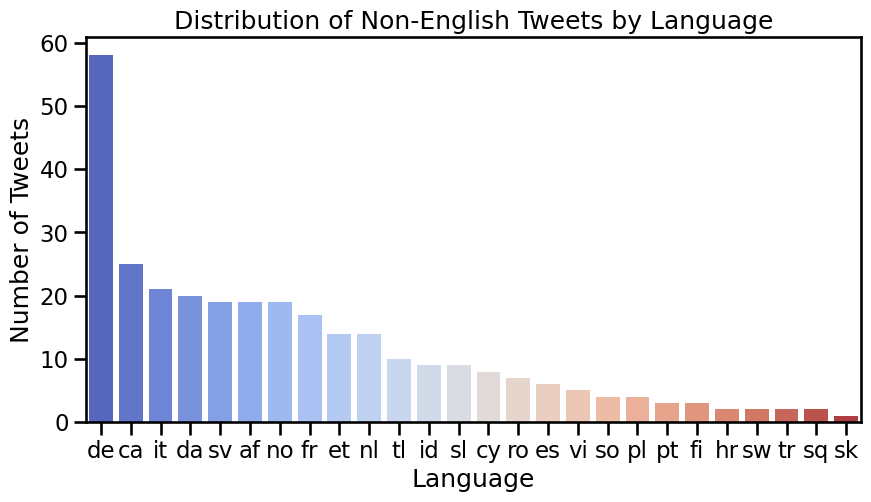


Class distribution per non-English language:
target   0   1
lang          
af      16   3
ca       9  16
cy       5   3
da      16   4
de      44  14
es       4   2
et      11   3
fi       3   0
fr      12   5
hr       2   0
id       9   0
it      17   4
nl      13   1
no      15   4
pl       4   0
pt       2   1
ro       3   4
sk       1   0
sl       3   6
so       4   0
sq       1   1
sv      15   4
sw       1   1
tl       8   2
tr       2   0
vi       2   3


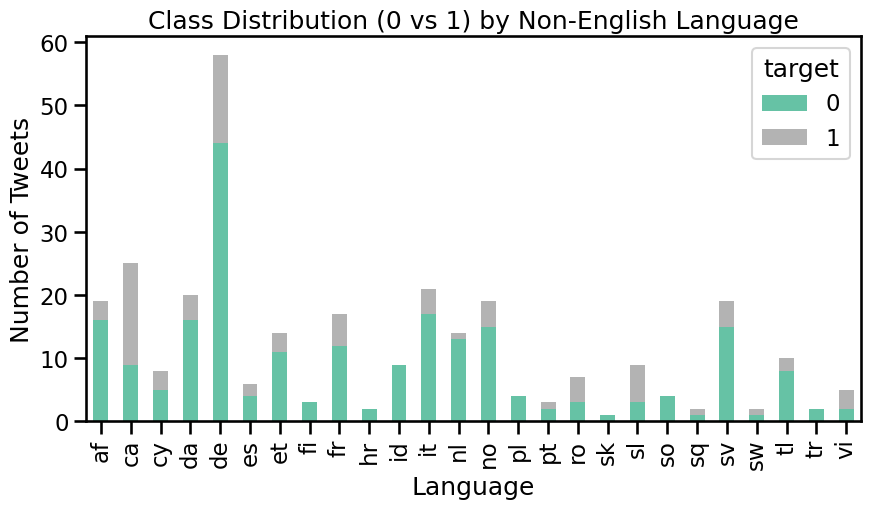

In [12]:
# Non-English tweets
non_en_df = train_df[train_df['lang'] != 'en']

if non_en_df.empty:
        print("All tweets are English. No non-English tweets to analyze.")
else:
        # Distribution languages
        print("Non-English tweets count by language:")
        print(non_en_df['lang'].value_counts())

        # Bar chart of language
        import matplotlib.pyplot as plt
        import seaborn as sns

        plt.figure(figsize=(10,5))
        sns.countplot(data=non_en_df, x='lang', order=non_en_df['lang'].value_counts().index, palette='coolwarm')
        plt.title("Distribution of Non-English Tweets by Language")
        plt.ylabel("Number of Tweets")
        plt.xlabel("Language")
        plt.show()

        # Checking classes in non-English
        lang_class_counts = non_en_df.groupby(['lang','target']).size().unstack(fill_value=0)
        print("\nClass distribution per non-English language:")
        print(lang_class_counts)

        # Stacked bar chart for classes per language
        lang_class_counts.plot(kind='bar', stacked=True, figsize=(10,5), colormap='Set2')
        plt.title("Class Distribution (0 vs 1) by Non-English Language")
        plt.ylabel("Number of Tweets")
        plt.xlabel("Language")
        plt.show()


In [13]:
#  Config & Seed

MODEL_NAME = "vinai/bertweet-base"
MAX_LEN = 128
BATCH_SIZE = 16
EPOCHS = 3
LR = 2e-5
N_SPLITS = 5
SEED = 42

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def set_seed(seed=SEED):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
set_seed()


In [14]:
# Load & Clean Data


train_df = pd.read_csv("train.csv").fillna("")
test_df  = pd.read_csv("test.csv").fillna("")

def clean_text(text):
    if not isinstance(text, str): return ""
    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    # Remove simple HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Standardize user mentions so model sees a mention token, not many unique usernames
    text = re.sub(r'@\w+', '@USER', text)
    # Remove digits (optional; keeps tokens more general)
    text = re.sub(r'\d+', '', text)
    # Collapse multiple spaces and strip
    text = re.sub(r'\s+', ' ', text).strip()
    return text

train_df["clean_text"] = train_df["text"].apply(clean_text)
test_df["clean_text"]  = test_df["text"].apply(clean_text)


In [15]:
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)
display(train_df.head(6)[['id','text','clean_text','location','keyword','target']])
# show a few random examples of cleaned vs raw
for i,row in train_df.sample(6, random_state=42).iterrows():
    print("RAW:", row['text'])
    print("CLEAN:", row['clean_text'])
    print("TARGET:", row.get('target','-'))
    print('-'*80)


Train shape: (7613, 6)
Test shape: (3263, 5)


,id,text,clean_text,location,keyword,target
0,1,Our Deeds are the Reason of this #earthquake M...,Our Deeds are the Reason of this #earthquake M...,,,1
1,4,Forest fire near La Ronge Sask. Canada,Forest fire near La Ronge Sask. Canada,,,1
2,5,All residents asked to 'shelter in place' are ...,All residents asked to 'shelter in place' are ...,,,1
3,6,"13,000 people receive #wildfires evacuation or...",", people receive #wildfires evacuation orders ...",,,1
4,7,Just got sent this photo from Ruby #Alaska as ...,Just got sent this photo from Ruby #Alaska as ...,,,1
5,8,#RockyFire Update => California Hwy. 20 closed...,#RockyFire Update => California Hwy. closed in...,,,1


RAW: So you have a new weapon that can cause un-imaginable destruction.
CLEAN: So you have a new weapon that can cause un-imaginable destruction.
TARGET: 1
--------------------------------------------------------------------------------
RAW: The f$&amp;@ing things I do for #GISHWHES Just got soaked in a deluge going for pads and tampons. Thx @mishacollins @/@
CLEAN: The f$&amp;@USER things I do for #GISHWHES Just got soaked in a deluge going for pads and tampons. Thx @USER @/@
TARGET: 0
--------------------------------------------------------------------------------
RAW: DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe CoL police can catch a pickpocket in Liverpool Stree... http://t.co/vXIn1gOq4Q
CLEAN: DT @USER: RT @USER: ÛÏThe CoL police can catch a pickpocket in Liverpool Stree...
TARGET: 1
--------------------------------------------------------------------------------
RAW: Aftershock back to school kick off was great. I want to thank everyone for making it possible. What a great ni

In [16]:
# 6) Torch Dataset

class TweetDataset(Dataset):
    def __init__(self, texts, targets, tokenizer, max_len):
        self.texts, self.targets, self.tokenizer, self.max_len = texts, targets, tokenizer, max_len
    def __len__(self): return len(self.texts)
    def __getitem__(self, idx):
        text, target = str(self.texts[idx]), self.targets[idx]
        encoding = self.tokenizer.encode_plus(
            text, add_special_tokens=True, max_length=self.max_len,
            padding="max_length", truncation=True,
            return_attention_mask=True, return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
            "targets": torch.tensor(target, dtype=torch.long)
        }


Tip:
If you see many tweets with token length > MAX_LEN, consider increasing it or summarizing tweets—watch GPU memory.

In [17]:
def train_epoch(model, loader, loss_fn, optimizer, scheduler):
    model.train()
    losses = []
    for batch in loader:
        input_ids = batch["input_ids"].to(device)
        attn = batch["attention_mask"].to(device)
        targets = batch["targets"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attn)
        loss = loss_fn(outputs.logits, targets)
        losses.append(loss.item())

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    return np.mean(losses)

def eval_model(model, loader):
    model.eval()
    preds, actuals, logits_list = [], [], []
    with torch.no_grad():
        for batch in loader:
            input_ids = batch["input_ids"].to(device)
            attn = batch["attention_mask"].to(device)
            targets = batch["targets"].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attn)
            _, p = torch.max(outputs.logits, dim=1)
            preds.extend(p.cpu().numpy())
            actuals.extend(targets.cpu().numpy())
            logits_list.append(outputs.logits.cpu())
    return f1_score(actuals, preds), preds, torch.cat(logits_list)

In [18]:
# 7) Phase 2: BERTweet Training (OOF + Test Probs)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, normalization=True)

oof_preds = np.zeros(len(train_df))
oof_probs = np.zeros(len(train_df))
test_logits_list = []

skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
for fold, (tr_idx, val_idx) in enumerate(skf.split(train_df, train_df["target"])):
    print(f"\n--- Fold {fold+1}/{N_SPLITS} ---")
    tr, val = train_df.iloc[tr_idx], train_df.iloc[val_idx]

    train_ds = TweetDataset(tr.clean_text.values, tr.target.values, tokenizer, MAX_LEN)
    val_ds   = TweetDataset(val.clean_text.values, val.target.values, tokenizer, MAX_LEN)
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

    model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2).to(device)
    optimizer = AdamW(model.parameters(), lr=LR)
    total_steps = len(train_loader) * EPOCHS
    scheduler = get_linear_schedule_with_warmup(optimizer, 0, total_steps)
    loss_fn = torch.nn.CrossEntropyLoss().to(device)

    best_f1 = 0
    for epoch in range(EPOCHS):
        train_loss = train_epoch(model, train_loader, loss_fn, optimizer, scheduler)
        val_f1, _, _ = eval_model(model, val_loader)
        print(f"  Epoch {epoch+1}/{EPOCHS} | Train Loss={train_loss:.4f}, Val F1={val_f1:.4f}")
        best_f1 = max(best_f1, val_f1)

    val_f1, val_preds, val_logits = eval_model(model, val_loader)
    oof_preds[val_idx] = val_preds
    oof_probs[val_idx] = F.softmax(val_logits, dim=1)[:,1].numpy()

    test_ds = TweetDataset(test_df.clean_text.values, np.zeros(len(test_df)), tokenizer, MAX_LEN)
    test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    _, _, test_logits = eval_model(model, test_loader)
    test_logits_list.append(test_logits)

    del model, optimizer, scheduler
    torch.cuda.empty_cache()

print("\nOOF F1 (BERTweet):", f1_score(train_df["target"], oof_preds))
avg_test_logits = torch.mean(torch.stack(test_logits_list), dim=0)
bert_test_probs = F.softmax(avg_test_logits, dim=1)[:,1].numpy()

# Save Phase2 outputs
pd.DataFrame({"id": train_df["id"], "oof_prob_disaster": oof_probs}).to_csv("phase2_oof_preds.csv", index=False)
pd.DataFrame({"id": test_df["id"], "test_prob_disaster": bert_test_probs}).to_csv("phase2_test_probs.csv", index=False)

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0



--- Fold 1/5 ---


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Epoch 1/3 | Train Loss=0.4544, Val F1=0.8118
  Epoch 2/3 | Train Loss=0.3345, Val F1=0.8135
  Epoch 3/3 | Train Loss=0.2686, Val F1=0.8214

--- Fold 2/5 ---


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Epoch 1/3 | Train Loss=0.4515, Val F1=0.8049
  Epoch 2/3 | Train Loss=0.3494, Val F1=0.8098
  Epoch 3/3 | Train Loss=0.2916, Val F1=0.8132

--- Fold 3/5 ---


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Epoch 1/3 | Train Loss=0.4454, Val F1=0.7884
  Epoch 2/3 | Train Loss=0.3286, Val F1=0.8023
  Epoch 3/3 | Train Loss=0.2650, Val F1=0.7994

--- Fold 4/5 ---


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Epoch 1/3 | Train Loss=0.4558, Val F1=0.8054
  Epoch 2/3 | Train Loss=0.3381, Val F1=0.8124
  Epoch 3/3 | Train Loss=0.2758, Val F1=0.8091

--- Fold 5/5 ---


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Epoch 1/3 | Train Loss=0.4380, Val F1=0.7975
  Epoch 2/3 | Train Loss=0.3381, Val F1=0.8026
  Epoch 3/3 | Train Loss=0.2746, Val F1=0.7994

OOF F1 (BERTweet): 0.8084973445798188


In [19]:
# 8) Phase 3: Feature Extraction + LightGBM

def extract_basic_features(df):
    features = pd.DataFrame(index=df.index)
    features['text_length'] = df['text'].str.len()
    features['capitals_ratio'] = df['text'].str.count('[A-Z]') / (features['text_length']+1)
    features['hashtag_count'] = df['text'].str.count('#')
    features['location_missing'] = (df['location']=='').astype(int)
    features['keyword_missing'] = (df['keyword']=='').astype(int)
    features['mention_count'] = df['text'].str.count(r'@\w+')
    features['url_count'] = df['text'].str.count(r'http\S+|www\.\S+')
    features['number_count'] = df['text'].str.count(r'\d+')
    features['exclaim_count'] = df['text'].str.count(r'!+')
    features['question_count'] = df['text'].str.count(r'\?+')
    return features.fillna(0)

def extract_advanced_features(df):
    features = pd.DataFrame(index=df.index)
    text_lower = df['clean_text'].str.lower()
    features['sentiment'] = df['clean_text'].apply(lambda x: TextBlob(x).sentiment.polarity)
    features['subjectivity'] = df['clean_text'].apply(lambda x: TextBlob(x).sentiment.subjectivity)
    features['word_count'] = df['clean_text'].apply(lambda x: len(str(x).split()))
    features['unique_word_count'] = df['clean_text'].apply(lambda x: len(set(str(x).split())))
    features['unique_word_ratio'] = features['unique_word_count'] / (features['word_count']+1e-6)
    features['char_count'] = df['clean_text'].apply(len)
    disaster_keywords = ['fire','flood','earthquake','storm','hurricane','tornado','quake','crash','accident','bomb','explosion']
    features['disaster_kw_count'] = sum([text_lower.str.count(fr'\b{w}\b') for w in disaster_keywords])
    disaster_prone_locs = ['california','japan','texas','florida','philippines','indonesia','india','china','houston','new orleans','mumbai','tokyo']
    loc_pattern = r'\b(' + '|'.join(disaster_prone_locs) + r')\b'
    features['is_in_disaster_prone_location'] = (text_lower.str.contains(loc_pattern) | df['location'].str.lower().str.contains(loc_pattern)).astype(int)
    urgency_words = ['breaking','now','urgent','alert','just in']
    features['urgency_word_count'] = text_lower.str.count(r'\b(' + '|'.join(urgency_words) + r')\b')
    return features.fillna(0)

vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=3, max_df=0.9, max_features=5000)
X_train_tfidf = vectorizer.fit_transform(train_df["clean_text"])
X_test_tfidf  = vectorizer.transform(test_df["clean_text"])

train_basic = extract_basic_features(train_df)
test_basic = extract_basic_features(test_df)
train_adv = extract_advanced_features(train_df)
test_adv = extract_advanced_features(test_df)

train_bert_feats = oof_probs.reshape(-1,1)
test_bert_feats = bert_test_probs.reshape(-1,1)

X_train = hstack([X_train_tfidf, csr_matrix(train_basic.values), csr_matrix(train_adv.values), csr_matrix(train_bert_feats)]).tocsr()
X_test  = hstack([X_test_tfidf, csr_matrix(test_basic.values), csr_matrix(test_adv.values), csr_matrix(test_bert_feats)]).tocsr()
y_train = train_df["target"].values

print("Total features for LGBM:", X_train.shape[1])

lgb_params = {"objective":"binary","boosting_type":"gbdt","n_estimators":10000,
              "learning_rate":0.01,"num_leaves":20,"max_depth":5,
              "seed":SEED,"n_jobs":-1,"verbose":-1,
              "colsample_bytree":0.7,"subsample":0.7,"reg_alpha":0.1,"reg_lambda":0.1}

oof_preds_lgbm = np.zeros(len(train_df))
test_preds_lgbm_prob = np.zeros(len(test_df))

skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
for fold, (tr_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
    print(f"\n--- LGBM Fold {fold+1}/{N_SPLITS} ---")
    X_tr, X_val = X_train[tr_idx], X_train[val_idx]
    y_tr, y_val = y_train[tr_idx], y_train[val_idx]
    model = lgb.LGBMClassifier(**lgb_params)
    model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], eval_metric='binary_logloss', callbacks=[lgb.early_stopping(100, verbose=False)])
    val_proba = model.predict_proba(X_val)[:,1]
    oof_preds_lgbm[val_idx] = (val_proba>0.5).astype(int)
    test_preds_lgbm_prob += model.predict_proba(X_test)[:,1] / N_SPLITS

print("Overall OOF F1 (LGBM):", f1_score(y_train, oof_preds_lgbm))

pd.DataFrame({"id": test_df["id"], "test_prob_disaster": test_preds_lgbm_prob}).to_csv("phase3_test_probs.csv", index=False)
pd.DataFrame({"id": test_df["id"], "target": (test_preds_lgbm_prob>0.5).astype(int)}).to_csv("phase3_lgbm_submission.csv", index=False)
print("Phase3 outputs saved.")

/var/folders/66/qj0pgbn10_n7_txykj6jtj2c0000gn/T/ipykernel_84658/3235369934.py:30: UserWarning:

This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.

/var/folders/66/qj0pgbn10_n7_txykj6jtj2c0000gn/T/ipykernel_84658/3235369934.py:30: UserWarning:

This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.



Total features for LGBM: 5020

--- LGBM Fold 1/5 ---


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names




--- LGBM Fold 2/5 ---


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names




--- LGBM Fold 3/5 ---


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names




--- LGBM Fold 4/5 ---


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names




--- LGBM Fold 5/5 ---
Overall OOF F1 (LGBM): 0.8072942336126171
Phase3 outputs saved.


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names



In [20]:
# 9) Phase 4: Final Ensemble

bert_probs_df = pd.read_csv("phase2_test_probs.csv")
lgbm_probs_df = pd.read_csv("phase3_test_probs.csv")

final_probs = 0.7*bert_probs_df['test_prob_disaster'] + 0.3*lgbm_probs_df['test_prob_disaster']
final_preds = (final_probs>0.5).astype(int)

submission_df_final = pd.DataFrame({"id": test_df["id"], "target": final_preds})
submission_df_final.to_csv("submission.csv", index=False)
print("Final ensemble submission saved as final_ensemble_submission.csv")

Final ensemble submission saved as final_ensemble_submission.csv
